# Spin circuits

In addition to the fermionic setting introduced in [the first tutorial](./01_introduction_and_fermionic_circuits.ipynb), the Qiskit cold atom module supports a framework to describe cold atomic architectures based on high-dimensional spins.

Here, the unit of information, i.e. the individual wires in the quantum circuit, are given as quantum angular momenta or spins of length $S$, where $S$ can take positive integer or half-integer values. This can be seen as a generalization of the qubit setting (i.e. a qudit) where the qubit case corresponds to the smallest possible value $S=\frac{1}{2}$.

Each individual spin has $2S+1$ internal states which are labeled from  $\left| 0 \right>$ to  $\left| 2S \right>$. In analogy to qubits, we use the convention that each wire is initialized in the $\left| 0 \right>$ state at the start of a circuit. A measurement of a wire will project that spin to one of the eigenstates and return the measured outcome from $0$ to $2S$.   

The spin module comes with a `SpinSimulator()` backend which serves as a general-purpose simulation backend analogous to the `FermionSimulator` for fermionic circuits.

In [1]:
from qiskit_cold_atom.spins import SpinSimulator
from qiskit import QuantumCircuit, QuantumRegister

backend = SpinSimulator()
qc = QuantumCircuit(4)
qc.measure_all()
# confirm that an empty circuit will return '0 0 0 0'
job = backend.run(qc, spin=3)

print(job.result().get_counts())

{'0 0 0 0': 1000}


## Spin Gates

Quantum gates define the unitary operations that are carried out on the system. The gate unitary $U$ can be uniquely identified by the hermitian Hamiltonian $H$ that generates the evolution of the state (see [Qiskit textbook](https://qiskit.org/textbook/ch-gates/proving-universality.html#2.2-Unitary-and-Hermitian-matrices-)) as $U = e^{-i H}$.
The description of the dynamics of cold atomic quantum simulators commonly takes place on the level of the Hamiltonian which the system implements. We therefore choose a language which defines the spin gates from their generating Hamiltonians.

As a formal language to describe Hamiltonians for spin systems, we utilize the 
`SpinOp` from Qiskit Nature. Gates are then defined as instances or subclasses of the `SpinGate` class which inherits from Qiskit's original `Gate` class. 

In order for the `SpinSimulator` to run a circuit, each gate of the circuit needs to have its generating Hamiltonian given as a `SpinOp`.  

As a first example, let's look at the generalization of a $\pi$-rotation around the $X$-axis:

In [2]:
from qiskit_nature.operators.second_quantization import SpinOp
from qiskit_cold_atom.spins import SpinGate
import numpy as np

Hx = np.pi*SpinOp("X")  # generator of a rotation of angle pi around the x-axis

rx_spin = SpinGate(name="rx_spin", num_modes=1, generator=Hx)

For details on the syntax of how to define a SpinOp please see the [SpinOp documentation](https://qiskit.org/documentation/nature/stubs/qiskit_nature.operators.second_quantization.SpinOp.html#qiskit_nature.operators.second_quantization.SpinOp). 

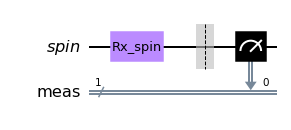

In [4]:
qc = QuantumCircuit(QuantumRegister(1, "spin"))

qc.append(rx_spin, [0])
qc.measure_all()
qc.draw(output='mpl')

In [5]:
job = backend.run(qc, spin=10)
print(job.result().get_counts())

{'20': 1000}


After applying the x-rotation, the spin has been flipped from pointing all the way "up" (0) to pointing all the way "down" to its largest value $2S = 20$.

Note that for the definition of the gate, the length of the spin $S$ is not yet given explicitly. Rather, when running the job on the spin simulator backend, $S$ is given as an additional parameter of the simulation. The same circuit can thus be recycled and simulated with a different spin length:

In [6]:
job = backend.run(qc, spin=6)
print(job.result().get_counts())

{'12': 1000}


### Example: Superposition

As is the case for qubit systems, superpositions in the initial states can be created by rotating around the x-axis with an angle $\phi \neq \pi$.
Such a parameterized rotation gate is defined in the `SpinGateLibrary`, it is called the `LXGate` (as $L$ usually denotes the angular momentum in the cold atom community). Let's see what state is created when rotating with an angle of $\phi= \frac{\pi}{2}$: 

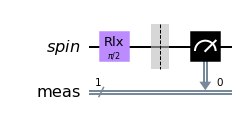

In [7]:
from qiskit_cold_atom.spins import RLXGate

qc = QuantumCircuit(QuantumRegister(1, "spin"))
qc.append(RLXGate(np.pi/2), [0])
qc.measure_all()
qc.draw(output='mpl')

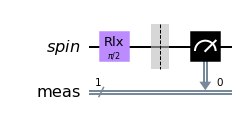

In [8]:
# The same circuit can also be built by the following shorthand notation
# which is added to QuantumCircuit upon importing from qiskit_cold_atom.spins
qc = QuantumCircuit(QuantumRegister(1, "spin"))
qc.rlx(np.pi/2, 0)
qc.measure_all()
qc.draw(output='mpl')

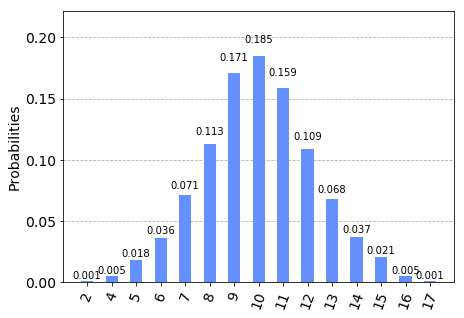

In [9]:
from qiskit.visualization import plot_histogram

job = backend.run(qc, spin=10, shots=1000, seed=123)

counts = job.result().get_counts()
# convert counts to integers for better formatting
plot_histogram({int(k):v for k,v in counts.items()})

We see from the above result that a single rotation creates a superposition of all possible values, where the value "in the middle" $S=10$ is most likely to be measured. The measurement outcomes follows a binomial distribution with $p=\frac{1}{2}$. 

### Example: Multi-spin gates

We can also use the language of generating Hamiltonians to create multi-spin gates. As an example, we can use a ZZ-type interaction to create an equal superposition between the different combinations of extremal spin orientations $0$ and $2S$:

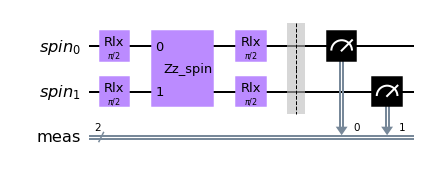

In [10]:
Hzz = np.pi*SpinOp("Z_0 Z_1", register_length=2)  # generating Hamiltonian acting on two spins

zz_gate = SpinGate(name="zz_spin", num_modes=2, generator=Hzz)

qc = QuantumCircuit(QuantumRegister(2, "spin"))

qc.rlx(np.pi/2, [0, 1])
qc.append(zz_gate, [0, 1])
qc.rlx(np.pi/2, [0, 1])
qc.measure_all()

qc.draw(output='mpl')

Note that we could have achieved the same result by using the
```python
qc.rlzlz(np.pi, [0, 1])

```
instruction.

counts:  {'2 0': 231, '2 2': 267, '0 0': 249, '0 2': 253}


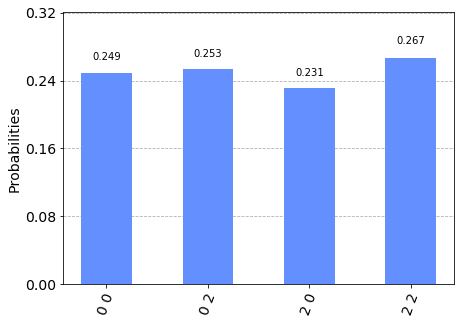

In [11]:
job = backend.run(qc, spin=1, shots=1000, seed=1234)

print("counts: ", job.result().get_counts())

plot_histogram(job.result().get_counts())

The measured counts are returned in a space delimited format, where the first entry corresponds to the last spin in the register, etc. When executing circuits with spin-1/2, this recovers Qiskit's ordering of bitstrings for qubits. 

## The spin simulator backend

The `SpinSimulator` backend can also be used to access the statevector and the unitary of the circuit.  Internally, the backend simulates the evolution of the circuit by exact diagonalization. The statevector and unitary of the system can be retrieved in the familiar way of `result.get_statevector()` and `result.get_unitary()`. If there is a final measurement in the circuit, the returned state and unitary of the circuit are those just prior to measurement.

Let's demonstrate this on the above circuit:

In [12]:
# access the statevector 
print("\nstatevector :", job.result().get_statevector())

# accedd the unitary
print("\ncircuit unitary : \n", job.result().get_unitary())


statevector : [-5.00000000e-01-1.36845553e-48j -1.30736460e-32+1.11022302e-16j
  5.00000000e-01-1.36845553e-48j -1.23259516e-32+1.34015774e-16j
 -6.16297582e-33+6.12323400e-17j  0.00000000e+00+2.29934717e-17j
  5.00000000e-01+3.42113883e-49j  4.35788200e-33+1.77904863e-17j
  5.00000000e-01+3.42113883e-49j]

circuit unitary : 
 [[-5.00000000e-01-1.36845553e-48j -1.54074396e-32+1.66533454e-16j
   5.00000000e-01+1.36845553e-48j -1.23259516e-32+1.25886354e-16j
   1.38777878e-17+6.12323400e-17j  6.16297582e-33+7.03752031e-17j
   5.00000000e-01+3.42113883e-49j  6.16297582e-33+3.74166420e-17j
   5.00000000e-01-3.42113883e-49j]
 [-1.30736460e-32+1.11022302e-16j  1.00000000e+00+0.00000000e+00j
   1.30736460e-32+0.00000000e+00j -6.16297582e-33+6.12323400e-17j
   1.23259516e-32-1.37383090e-16j -6.16297582e-33-6.12323400e-17j
   4.35788200e-33+3.74166420e-17j -3.92523115e-17+0.00000000e+00j
  -4.35788200e-33+3.74166420e-17j]
 [ 5.00000000e-01-1.36845553e-48j  1.54074396e-32-5.55111512e-17j
  -5.0

For the above circuit with two spins of length $S=1$, the total dimension of the Hilbert space becomes $(2S+1)^2 = 9$. The state ordering in the basis in this case is (0 0), (1 0), (2 0), (0 1), (1 1), (2 1), (0 2), (1 2), (2 2). 

### Further remarks

The `SpinSimulator` is a general simulator backend in the sense that it accepts any `SpinGate` with a well-defined generator. Similar to the `qasm_simulator` for qubits, there are no coupling maps or further restrictions posed on the applicable gates. 

In order to see how the spin setting introduced here can be used to describe a concrete experimental system of ultracold bosonic atoms with a gateset and coupling maps of a real device, check out the [collective spins hardware tutorial](./04_collective_spin_hardware.ipynb).

In [13]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright